# Functions: data loading, concat + filter/trim the data, calculate results

In [1]:
import functions as f
import importlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
importlib.reload(f)
indices = ['sp500', 'ftse100', 'nikkei225']
data_dir = r"C:\\physics_masters\\data\\"


# SP500 results

In [ ]:
dataframes = f.load_data_foreign('sp500', data_dir)


In [72]:
importlib.reload(f)
df_concat = f.concat_dfs_by_date(dataframes, 0.9, None)

% of stocks remaining: 87.73%
% of dates remaining: 97.82%
Number of stocks: 529
Number of dates: 3772
% of nans: 0.95%


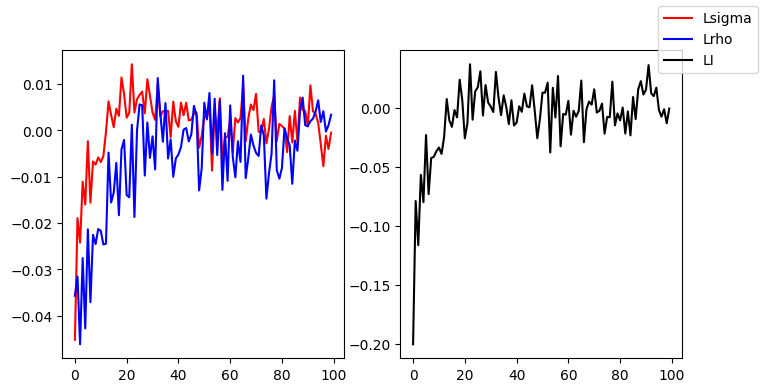

In [73]:
tau_list = np.arange(0, 100, 1)

rho_0 = f.rho(df_concat).mean()
sigma2_0 = (df_concat**2).mean(axis=1).mean()
LI_vals = f.LI(df_concat, tau_list)
Lsigma_vals = f.Lsigma(df_concat, tau_list)
Lrho_vals = f.Lrho(df_concat, tau_list)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

LI_vals.plot(ax=ax[1], label='LI', color='black')
(Lsigma_vals*rho_0).plot(ax=ax[0], label='Lsigma', color='red')
(Lrho_vals*sigma2_0).plot(ax=ax[0], label='Lrho', color='blue')

fig.legend()

In [74]:
rho_0*sigma2_0

np.float64(0.18131828000800346)

In [75]:
(((df_concat).mean(axis=1))**2).mean()

np.float64(0.25327788662526646)

# SP500 and FTSE100

In [2]:
indices = ['sp500', 'ftse100']


dataframes = []
for index in indices:
    dataframes += f.load_data_foreign(index, data_dir)
df_concat = f.concat_dfs_by_date(dataframes, 0.9, '2010')



% of stocks remaining: 87.73%
% of dates remaining: 97.82%
Number of stocks: 529
Number of dates: 3772
% of nans: 0.95%


<I^2> = 0.2533
rho_0*sigma2_0 = 0.1813
rhomean = 0.1815, rhostd = 0.1928


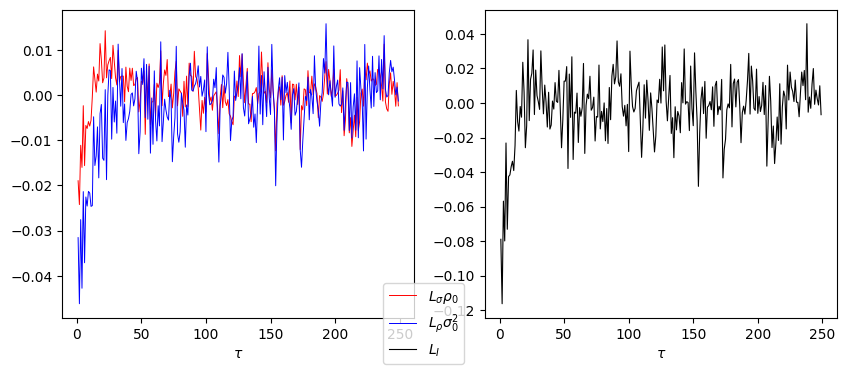

In [8]:
importlib.reload(f)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

f.plot(df_concat, fig, ax)


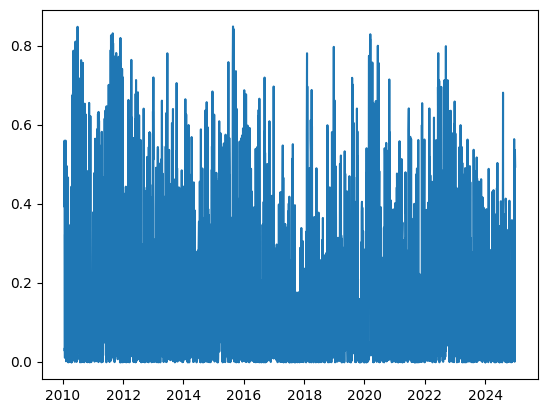

In [10]:
plt.plot(f.rho(df_concat))

In [78]:
df_concat.shape

(3772, 529)

# SP500 old

% of stocks remaining: 90.24%
% of dates remaining: 100.00%
Number of stocks: 379
Number of dates: 2765
% of nans: 1.33%


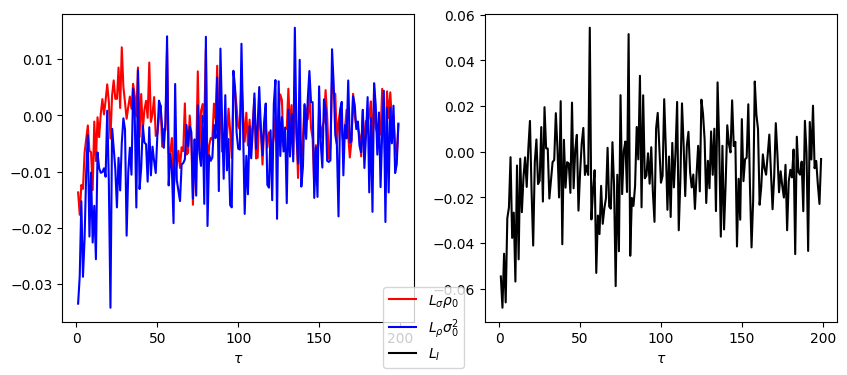

In [79]:
importlib.reload(f)
dataframes = f.load_data_foreign('sp500_old', data_dir)
df_concat_old = f.concat_dfs_by_date(dataframes, 0.7, None, last_traded=False)
tau_list = np.arange(1, 200, 1)
rho_0 = f.rho(df_concat_old).mean()
sigma2_0 = (df_concat_old**2).mean(axis=1).mean()
LI_vals_old = f.LI(df_concat_old, tau_list)
Lsigma_vals_old = f.Lsigma(df_concat_old, tau_list)
Lrho_vals_old = f.Lrho(df_concat_old, tau_list)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
LI_vals_old.plot(ax=ax[1], label=r'$L_I$', color='black')
(Lsigma_vals_old*rho_0).plot(ax=ax[0], label=r'$L_{\sigma}\rho_0$', color='red')
(Lrho_vals_old*sigma2_0).plot(ax=ax[0], label=r'$L_{\rho}\sigma_0^2$', color='blue')
ax[0].set_xlabel(r'$\tau$')
ax[1].set_xlabel(r'$\tau$')
fig.legend(loc='lower center')
plt.show()